In [41]:
import pandas_datareader.data as web
import datetime as dt 
import pandas as pd 
import matplotlib.pyplot as plt 
from arch import arch_model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import numpy as np

# 1) Load the Data

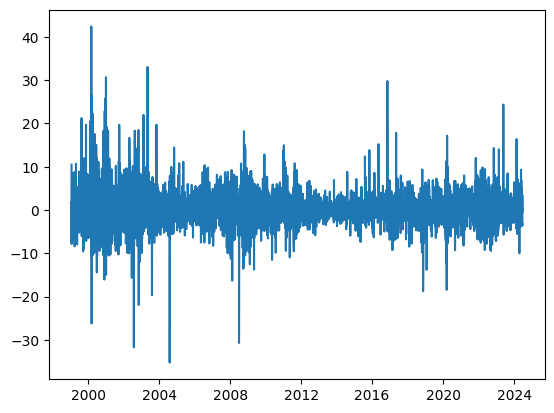

In [2]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime) # Turn dates into datetime objects (not strings)
df.index = df.pop('Date')
returns = 100*df['Close'].pct_change().dropna()
plt.plot(returns) # good candidate for GARCH because volatility changes over time

# 2) Fit a GARCH Model

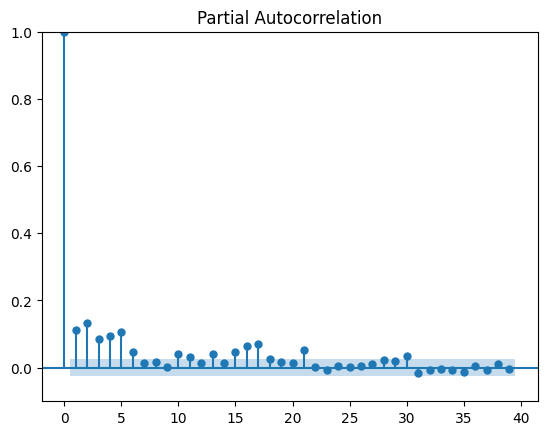

In [10]:
fig, ax = plt.subplots()
plot_pacf(returns**2,ax=ax)
ax.set_ylim(-0.1,1)
plt.show()

In [ ]:
model = arch_model(returns,p=1,q=1)
model_fit = model.fit()
model_fit.summary

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46632.13791804343
Iteration:      2,   Func. Count:     16,   Neg. LLF: 64828641687.79334
Iteration:      3,   Func. Count:     24,   Neg. LLF: 59058698.70378072
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16836.529474980336
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16709.396943628555
Iteration:      6,   Func. Count:     41,   Neg. LLF: 34366.30611894364
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17756.836524704602
Iteration:      8,   Func. Count:     56,   Neg. LLF: 23164.068091502253
Iteration:      9,   Func. Count:     62,   Neg. LLF: 16704.06314815948
Iteration:     10,   Func. Count:     67,   Neg. LLF: 16703.67579966765
Iteration:     11,   Func. Count:     72,   Neg. LLF: 16703.635284082105
Iteration:     12,   Func. Count:     77,   Neg. LLF: 16703.63405367086
Iteration:     13,   Func. Count:     82,   Neg. LLF: 16703.633989142523
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1670

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16703.6
Distribution:                  Normal   AIC:                           33415.3
Method:            Maximum Likelihood   BIC:                           33442.3
                                        No. Observations:                 6394
Date:                Sat, Jun 22 2024   Df Residuals:                     6393
Time:                        19:27:23   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2335  5.268e

In [ ]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

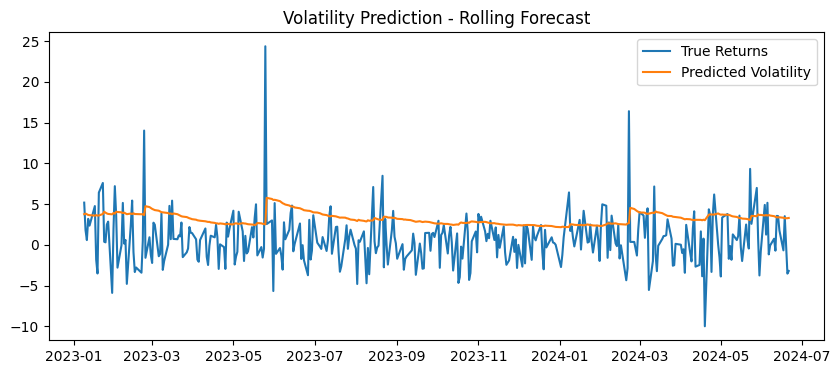

In [ ]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Returns','Predicted Volatility'])

In [ ]:
### Using the Model ###

train = returns 
model = arch_model(train, p=1,q=1)
model_fit = model.fit(disp='off')

pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + dt.timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

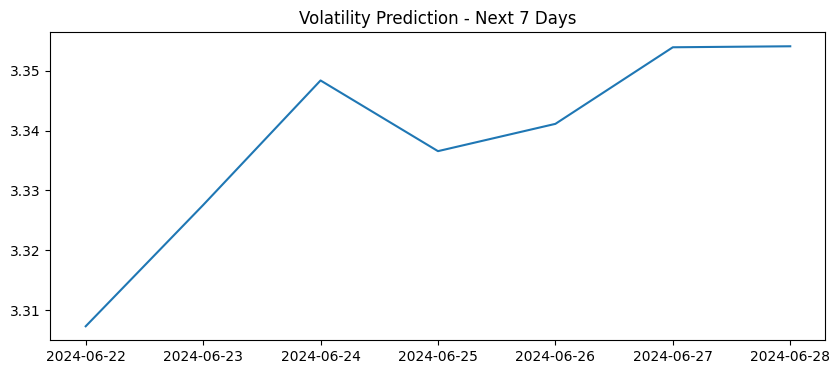

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days')

# 3) Fit an ARIMA Model 

In [15]:
price = df['Close']
price.describe()

count    6395.000000
mean        5.735178
std        14.335830
min         0.034115
25%         0.275750
50%         0.455750
75%         4.123375
max       135.580002
Name: Close, dtype: float64

## Determine d param
Number of differencing required to achieve stationarity: 1

In [20]:
# ADF Test for stationarity 
result = adfuller(price.dropna())
print(f"ADF Stat: {result[0]}")
print(f"P-Value: {result[1]}") # clearly, NVDA is not stationary

ADF Stat: 8.618906693214436
P-Value: 1.0


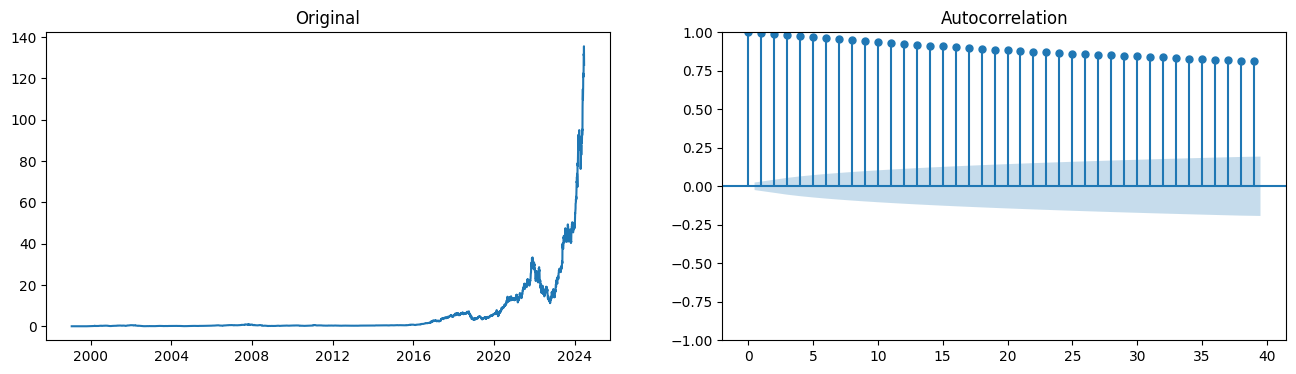

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(price)
ax1.set_title("Original")
plot_acf(price, ax=ax2);

(-0.25, 1.0)

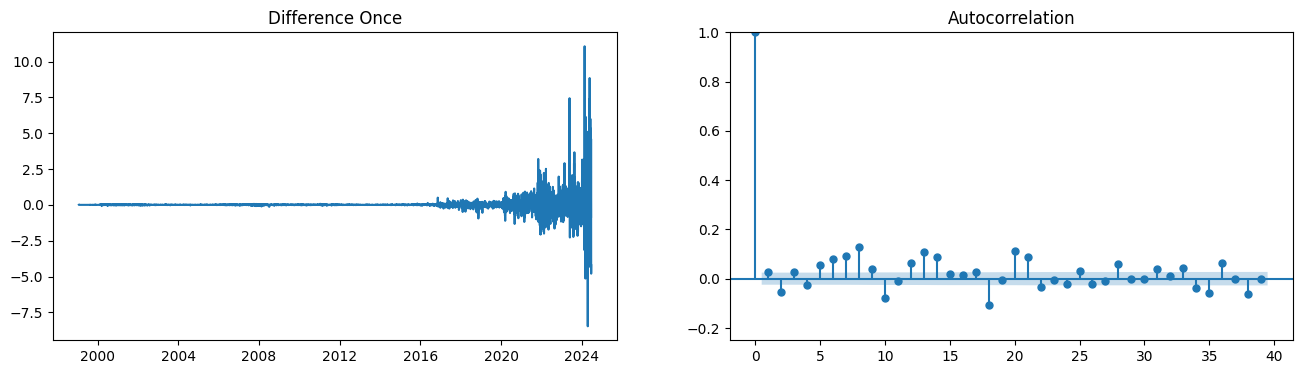

In [28]:
diff = price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax=ax2);
ax2.set_ylim(-0.25,1)

## Determine p param
Q: first autocorrelation lag that is outside of the acf range: 3

P: first autocorrelation lag that is outside of the pacf range: 3 

(-0.25, 1.0)

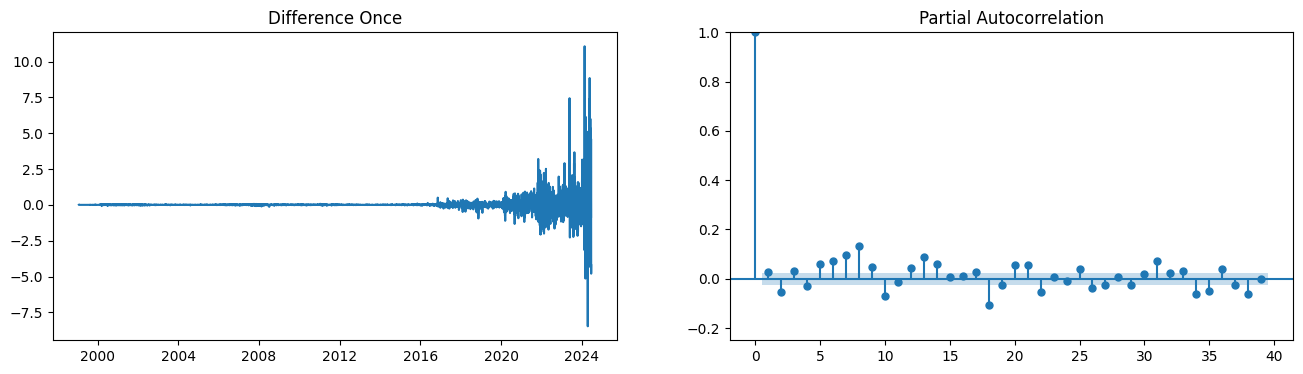

In [29]:
diff = price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_pacf(diff, ax=ax2);
ax2.set_ylim(-0.25,1)

In [35]:
mdl_arima = ARIMA(price, order=(3,1,3))
mdl_arima_fit = mdl_arima.fit()
mdl_arima_fit.summary()

C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 6395
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4355.831
Date:                Sat, 22 Jun 2024   AIC                           8725.661
Time:                        20:21:36   BIC                           8773.003
Sample:                             0   HQIC                          8742.049
                               - 6395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6936      0.013     52.095      0.000       0.668       0.720
ar.L2          0.9761      0.005    207.730      0.000       0.967       0.985
ar.L3         -0.7139      0.014    -52.724      0.000      -0.740      -0.687
ma.L1         -0.7416      0.013    -57.768      0.000      -0.767      -0.716
ma.L2         -0.9621      0.006   -153.991      0.000      -0.974      -0.950
ma.L3          0.7790      0.013     60.783      0.000       0.754       0.804
sigma2         0.2286      0.001    354.548      0.000       0.227       0.230
===================================================================================
Ljung-Box (L1) (Q):                  14.21   Jarque-Bera (JB):           3316402.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            5291.01   Skew:                             3.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       114.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(array([8.31741240e-05, 3.32696496e-04, 4.15870620e-04, 1.15612032e-02,
        5.11687211e-01, 5.90536280e-03, 1.33078598e-03, 2.49522372e-04,
        2.49522372e-04, 8.31741240e-05]),
 array([-8.29868163, -6.41862376, -4.5385659 , -2.65850804, -0.77845017,
         1.10160769,  2.98166555,  4.86172342,  6.74178128,  8.62183914,
        10.50189701]),
 <BarContainer object of 10 artists>)

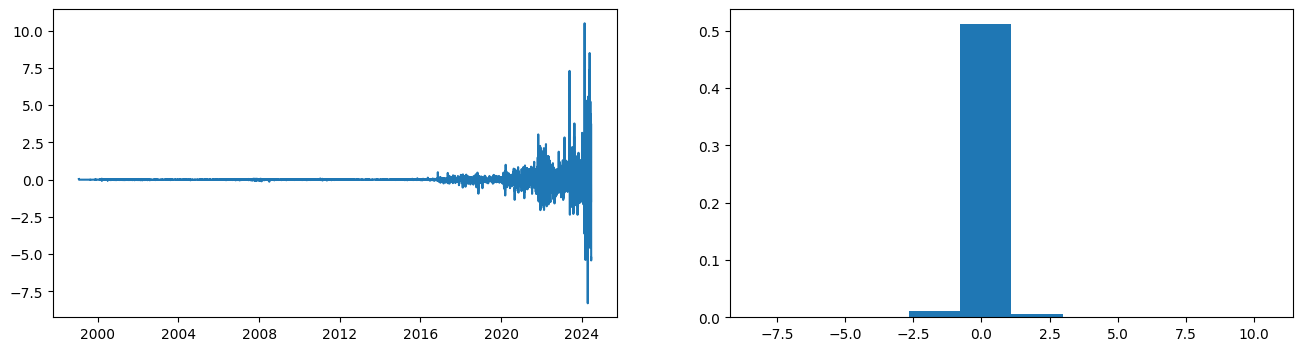

In [38]:
residuals = pd.DataFrame(mdl_arima_fit.resid)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals, density=True)

C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


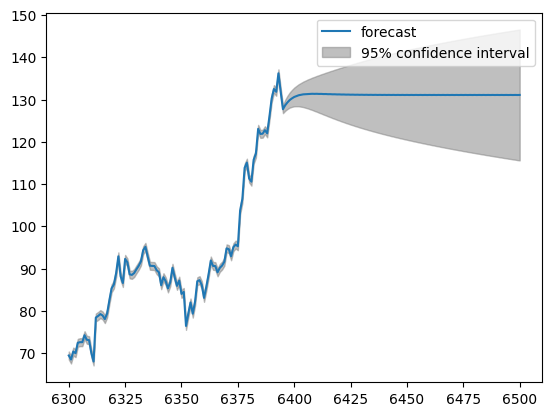

In [56]:
plot_predict(mdl_arima_fit,
    start = 6300, 
    end = 6500,
    dynamic = False
);